# Electricity Consumption Forecasting Using LSTM

In this example, the LSTM model is used to forecast electricity consumption for the Dublin City Council Civic Offices. Attributions provided below.

#### Attributions

The below code uses the LSTM model from the TensorFlow library, of which the original authors **(Copyright 2019 The TensorFlow Authors)** have made available under the Apache 2.0 license. Modifications have been made where appropriate for conducting analysis on the dataset specific to this example.

The dataset used in this example is sourced from [data.gov.ie](https://data.gov.ie/dataset/energy-consumption-gas-and-electricity-civic-offices-2009-2012/resource/6091c604-8c94-4b44-ac52-c1694e83d746).

The below work and findings are not endorsed by the original authors in any way.

#### Apache 2.0 License

In [11]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### Python version

In [12]:
from platform import python_version
print(python_version())

3.8.3


### Import Libraries

In [13]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [14]:
tf.random.set_seed(1234)

In [15]:
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf

from math import sqrt
from numpy.random import seed
seed(1)
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM

### Data Import and Manipulation

In [43]:
# fix random seed for reproducibility
np.random.seed(7)

# load dataset
df = pd.read_csv('Electric_Production.csv', engine='python', skipfooter=3)
df

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151
...,...,...
389,06-01-2017,102.1532
390,07-01-2017,112.1538
391,08-01-2017,108.9312
392,09-01-2017,98.6154


In [17]:
df2=df.rename(columns=df.iloc[0])
df3=df2.drop(df.index[0])
df3
df3.drop(df3.index[0])
df4=df3.drop('Date', axis=1)
df5=df4.drop('Values', axis=1)
df5
df6=df5.dropna()
df7=df6.values
df7
dataset=np.sum(df7, axis=1, dtype=float)
dataset

KeyError: "['Date'] not found in axis"

In [ ]:
tseries=dataset
tseries

In [ ]:
plt.plot(tseries)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('Consumption in kilowatts')
plt.title("Daily Consumption")
plt.show()

In [ ]:
df=pd.DataFrame(tseries)
df

In [18]:
df

,Consumption
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-06-01,102.1532
2017-07-01,112.1538
2017-08-01,108.9312


In [19]:
df=np.array(df)

### Training and Test data partition

In [20]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df[0:train_size,:], df[train_size:len(df),:]

### Form dataset matrix

In [21]:
def create_dataset(df, previous=1):
    dataX, dataY = [], []
    for i in range(len(df)-previous-1):
        a = df[i:(i+previous), 0]
        dataX.append(a)
        dataY.append(df[i + previous, 0])
    return np.array(dataX), np.array(dataY)

In [22]:
df

array([[ 72.5052],
       [ 70.672 ],
       [ 62.4502],
       [ 57.4714],
       [ 55.3151],
       [ 58.0904],
       [ 62.6202],
       [ 63.2485],
       [ 60.5846],
       [ 56.3154],
       [ 58.0005],
       [ 68.7145],
       [ 73.3057],
       [ 67.9869],
       [ 62.2221],
       [ 57.0329],
       [ 55.8137],
       [ 59.9005],
       [ 65.7655],
       [ 64.4816],
       [ 61.0005],
       [ 57.5322],
       [ 59.3417],
       [ 68.1354],
       [ 73.8152],
       [ 70.062 ],
       [ 65.61  ],
       [ 60.1586],
       [ 58.8734],
       [ 63.8918],
       [ 68.8694],
       [ 70.0669],
       [ 64.1151],
       [ 60.3789],
       [ 62.4643],
       [ 70.5777],
       [ 79.8703],
       [ 76.1622],
       [ 70.2928],
       [ 63.2384],
       [ 61.4065],
       [ 67.1097],
       [ 72.9816],
       [ 75.7655],
       [ 67.5152],
       [ 63.2832],
       [ 65.1078],
       [ 73.8631],
       [ 77.9188],
       [ 76.6822],
       [ 73.3523],
       [ 65.1081],
       [ 63.

### Normalize dataset with MinMaxScaler

#### Training Data

In [23]:
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
train

array([[0.26787164],
       [0.23930506],
       [0.11118556],
       [0.03360141],
       [0.        ],
       [0.04324723],
       [0.11383466],
       [0.12362539],
       [0.0821141 ],
       [0.01558758],
       [0.04184632],
       [0.20880153],
       [0.28034575],
       [0.19746342],
       [0.1076311 ],
       [0.02676831],
       [0.00776963],
       [0.07145384],
       [0.16284756],
       [0.14284067],
       [0.08859503],
       [0.03454885],
       [0.06274611],
       [0.19977748],
       [0.28828524],
       [0.22979949],
       [0.16042442],
       [0.07547578],
       [0.05544864],
       [0.13364987],
       [0.21121533],
       [0.22987585],
       [0.13712954],
       [0.0789087 ],
       [0.11140528],
       [0.2378356 ],
       [0.38264127],
       [0.32485831],
       [0.23339603],
       [0.12346801],
       [0.09492169],
       [0.18379409],
       [0.27529533],
       [0.31867658],
       [0.19011296],
       [0.12416612],
       [0.15259868],
       [0.289

#### Test Data

In [24]:
test = scaler.fit_transform(test)
test

array([[0.04909492],
       [0.06848274],
       [0.41592662],
       [0.73982174],
       [0.70954785],
       [0.32466354],
       [0.07629781],
       [0.17038664],
       [0.5388424 ],
       [0.66509893],
       [0.43084557],
       [0.16405665],
       [0.        ],
       [0.14179676],
       [0.37013704],
       [0.69428557],
       [0.60775295],
       [0.25032495],
       [0.07694907],
       [0.18488867],
       [0.48273626],
       [0.76146307],
       [0.52256917],
       [0.42067889],
       [0.09408065],
       [0.09283264],
       [0.35803021],
       [0.615598  ],
       [0.56185164],
       [0.31947801],
       [0.11527782],
       [0.26509947],
       [0.7062071 ],
       [1.        ],
       [0.69007284],
       [0.46886368],
       [0.07439309],
       [0.12473057],
       [0.39024696],
       [0.57204557],
       [0.56235302],
       [0.3504413 ],
       [0.1315347 ],
       [0.33098808],
       [0.59379045],
       [0.89140369],
       [0.78538243],
       [0.460

### Configure LSTM model

In [25]:
# Lookback period
lookback = 5
X_train, Y_train = create_dataset(train, lookback)
X_test, Y_test = create_dataset(test, lookback)

In [26]:
X_train

array([[0.26787164, 0.23930506, 0.11118556, 0.03360141, 0.        ],
       [0.23930506, 0.11118556, 0.03360141, 0.        , 0.04324723],
       [0.11118556, 0.03360141, 0.        , 0.04324723, 0.11383466],
       ...,
       [0.8958844 , 0.89736166, 0.69820438, 0.52374133, 0.58373394],
       [0.89736166, 0.69820438, 0.52374133, 0.58373394, 0.91957041],
       [0.69820438, 0.52374133, 0.58373394, 0.91957041, 1.        ]])

In [27]:
Y_train

array([0.04324723, 0.11383466, 0.12362539, 0.0821141 , 0.01558758,
       0.04184632, 0.20880153, 0.28034575, 0.19746342, 0.1076311 ,
       0.02676831, 0.00776963, 0.07145384, 0.16284756, 0.14284067,
       0.08859503, 0.03454885, 0.06274611, 0.19977748, 0.28828524,
       0.22979949, 0.16042442, 0.07547578, 0.05544864, 0.13364987,
       0.21121533, 0.22987585, 0.13712954, 0.0789087 , 0.11140528,
       0.2378356 , 0.38264127, 0.32485831, 0.23339603, 0.12346801,
       0.09492169, 0.18379409, 0.27529533, 0.31867658, 0.19011296,
       0.12416612, 0.15259868, 0.28903166, 0.35223124, 0.33296142,
       0.28107192, 0.15260336, 0.13049278, 0.2050258 , 0.29163401,
       0.30744598, 0.21800791, 0.16453051, 0.21435061, 0.45003109,
       0.45260071, 0.34060328, 0.27864254, 0.18641825, 0.16372487,
       0.25166854, 0.33189867, 0.33955299, 0.27653262, 0.18888659,
       0.20649527, 0.34857081, 0.47849326, 0.34659802, 0.28126982,
       0.18442208, 0.21038632, 0.3043294 , 0.38610847, 0.37158

In [28]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [29]:
X_train.shape[0]

309

In [30]:
X_train.shape[1]

1

Epoch 1/100
247/247 - 1s - loss: 0.0269 - val_loss: 0.0261
Epoch 2/100
247/247 - 0s - loss: 0.0119 - val_loss: 0.0198
Epoch 3/100
247/247 - 0s - loss: 0.0097 - val_loss: 0.0196
Epoch 4/100
247/247 - 0s - loss: 0.0082 - val_loss: 0.0126
Epoch 5/100
247/247 - 0s - loss: 0.0066 - val_loss: 0.0091
Epoch 6/100
247/247 - 0s - loss: 0.0052 - val_loss: 0.0076
Epoch 7/100
247/247 - 0s - loss: 0.0045 - val_loss: 0.0054
Epoch 8/100
247/247 - 0s - loss: 0.0038 - val_loss: 0.0048
Epoch 9/100
247/247 - 0s - loss: 0.0035 - val_loss: 0.0047
Epoch 10/100
247/247 - 0s - loss: 0.0035 - val_loss: 0.0048
Epoch 11/100
247/247 - 0s - loss: 0.0036 - val_loss: 0.0045
Epoch 12/100
247/247 - 0s - loss: 0.0034 - val_loss: 0.0045
Epoch 13/100
247/247 - 0s - loss: 0.0034 - val_loss: 0.0052
Epoch 14/100
247/247 - 0s - loss: 0.0034 - val_loss: 0.0054
Epoch 15/100
247/247 - 0s - loss: 0.0033 - val_loss: 0.0051
Epoch 16/100
247/247 - 0s - loss: 0.0034 - val_loss: 0.0045
Epoch 17/100
247/247 - 0s - loss: 0.0034 - val_lo

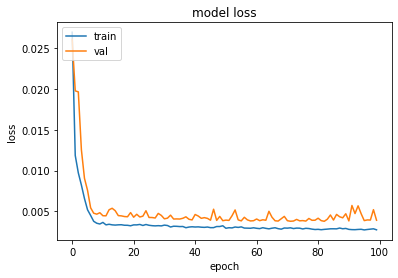

In [31]:
# Generate LSTM network
model = tf.keras.Sequential()
model.add(LSTM(4, input_shape=(1, lookback)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=1, verbose=2)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [37]:
# Generate predictions
trainpred = model.predict(X_train)
testpred = model.predict(X_test)

In [38]:
trainpred

array([[0.10917816],
       [0.15379342],
       [0.15715423],
       [0.11021951],
       [0.05872357],
       [0.02661289],
       [0.09997757],
       [0.25675914],
       [0.23373035],
       [0.11182902],
       [0.06425038],
       [0.08048215],
       [0.11992647],
       [0.16592932],
       [0.18918514],
       [0.10959247],
       [0.05784363],
       [0.05254336],
       [0.13235301],
       [0.24763274],
       [0.2483696 ],
       [0.14802901],
       [0.11213982],
       [0.1079857 ],
       [0.15130068],
       [0.22522452],
       [0.2361109 ],
       [0.18856603],
       [0.09384727],
       [0.0898879 ],
       [0.18810317],
       [0.30341306],
       [0.33926854],
       [0.22312093],
       [0.1604778 ],
       [0.13683277],
       [0.20794502],
       [0.30345413],
       [0.31023237],
       [0.26614228],
       [0.12811758],
       [0.12491138],
       [0.24199918],
       [0.3774571 ],
       [0.32344085],
       [0.25568786],
       [0.232142  ],
       [0.168

In [39]:
testpred

array([[ 0.38523373],
       [ 0.08023181],
       [ 0.00624653],
       [ 0.48075256],
       [ 0.78661364],
       [ 0.50970304],
       [ 0.21494439],
       [ 0.01750074],
       [ 0.09899737],
       [ 0.45467117],
       [ 0.50247604],
       [ 0.5071276 ],
       [ 0.33220115],
       [ 0.05522998],
       [ 0.04764908],
       [ 0.4917909 ],
       [ 0.67257684],
       [ 0.5662651 ],
       [ 0.27659932],
       [ 0.2604557 ],
       [ 0.08710726],
       [ 0.3326383 ],
       [ 0.6073048 ],
       [ 0.58110255],
       [ 0.33945638],
       [ 0.14204629],
       [ 0.08359495],
       [ 0.5155029 ],
       [ 0.80776364],
       [ 0.66067713],
       [ 0.3559225 ],
       [ 0.23067471],
       [ 0.07237182],
       [ 0.48761496],
       [ 0.71048987],
       [ 0.54963   ],
       [ 0.35230854],
       [ 0.19591606],
       [ 0.10483518],
       [ 0.5596896 ],
       [ 0.71167773],
       [ 0.6625002 ],
       [ 0.47891074],
       [ 0.2568857 ],
       [-0.02058388],
       [ 0

In [40]:
# Convert predictions back to normal values
trainpred = scaler.inverse_transform(trainpred)
Y_train = scaler.inverse_transform([Y_train])
testpred = scaler.inverse_transform(testpred)
Y_test = scaler.inverse_transform([Y_test])
predictions = testpred

ValueError: Found array with dim 3. Estimator expected <= 2.

In [41]:
Y_train.shape

(1, 309)

In [29]:
Y_test.shape

(1, 130)

In [30]:
X_train.shape

(538, 1, 5)

In [31]:
X_test.shape

(130, 1, 5)

In [32]:
Y_train

array([[4518.28951509, 4557.59113815, 4637.8424781 , 3011.6434176 ,
        2967.39742769, 4641.77260773, 4806.33226731, 4829.53286879,
        4775.27134202, 4630.74281586, 2905.40228055, 4539.71522927,
        4684.49726678, 4708.96572332, 4565.19789723, 3439.01669686,
        2931.89915677, 2919.60157603, 3383.3605489 , 4402.1595992 ,
        4580.28464288, 4654.83090304, 4468.33843892, 2984.00551222,
        2887.52640548, 3305.39123188, 4595.24459172, 4768.93231222,
        4839.67525246, 4746.9994882 , 3022.67323035, 2962.19943991,
        4673.34069105, 4782.24416242, 4849.94440544, 4840.18237672,
        4776.15877125, 3090.88053001, 2976.77908865, 4685.25797653,
        4682.34204071, 4678.66542886, 4614.00795392, 2958.64964103,
        2879.41252047, 4494.20145533, 4644.56177266, 4661.55021527,
        4712.76906743, 4715.93854042, 3006.57223143, 2871.29863554,
        4573.31180319, 4753.46528423, 4835.36475348, 4857.93146626,
        4597.01951125, 3012.78443227, 2912.12160

In [33]:
Y_test

array([[4756.5, 4855. , 4877.5, 4777.5, 4636.5, 3140. , 2950. , 4711. ,
        4894.5, 4589. , 4354.5, 4304. , 2745.5, 2639. , 4335. , 4442.5,
        4417.5, 4370.5, 4240.5, 2549.5, 2486.5, 4184.5, 4369. , 4432. ,
        4437. , 2722.5, 2451.5, 4403. , 4491. , 4468. , 4481.5, 4361.5,
        2432. , 4340.5, 4498.5, 4506. , 4459.5, 4407. , 2562.5, 2469. ,
        4304.5, 4430.5, 4449.5, 4484. , 4335. , 2695. , 2451. , 4500. ,
        4581. , 4679. , 4696. , 4632.5, 2873. , 2643. , 4475. , 4771. ,
        4965. , 4987.5, 4809. , 3042.5, 2769. , 4774.5, 4660.5, 4576. ,
        4589. , 4491.5, 2774.5, 2630.5, 4564. , 4640. , 4540.5, 4547.5,
        4399. , 2658.5, 2572.5, 3622.5, 2584.5, 2599.5, 2650. , 2576. ,
        2460. , 2330.5, 2560.5, 2803. , 4152. , 4252. , 4177.5, 2566.5,
        2512. , 4333.5, 4477.5, 4644.5, 4646.5, 4487.5, 2741.5, 2637. ,
        4518. , 4579.5, 4589. , 4537. , 4526. , 2771. , 2510. , 4639. ,
        4731. , 4709.5, 4638.5, 4454. , 2869.5, 2503.5, 4448.5, 

In [34]:
X_train

array([[[0.86253241, 0.921413  , 0.24695818, 0.26437424, 0.8393428 ]],

       [[0.921413  , 0.24695818, 0.26437424, 0.8393428 , 0.82340591]],

       [[0.24695818, 0.26437424, 0.8393428 , 0.82340591, 0.83819764]],

       ...,

       [[0.79366336, 0.8323127 , 0.84471866, 0.82467826, 0.77903069]],

       [[0.8323127 , 0.84471866, 0.82467826, 0.77903069, 0.2258521 ]],

       [[0.84471866, 0.82467826, 0.77903069, 0.2258521 , 0.18179503]]])

In [35]:
X_test

array([[[0.95295446, 0.95558901, 0.91738803, 0.31802785, 0.23372224]],

       [[0.95558901, 0.91738803, 0.31802785, 0.23372224, 0.91305984]],

       [[0.91738803, 0.31802785, 0.23372224, 0.91305984, 0.95013173]],

       [[0.31802785, 0.23372224, 0.91305984, 0.95013173, 0.95859992]],

       [[0.23372224, 0.91305984, 0.95013173, 0.95859992, 0.92096349]],

       [[0.91305984, 0.95013173, 0.95859992, 0.92096349, 0.86789612]],

       [[0.95013173, 0.95859992, 0.92096349, 0.86789612, 0.30466692]],

       [[0.95859992, 0.92096349, 0.86789612, 0.30466692, 0.2331577 ]],

       [[0.92096349, 0.86789612, 0.30466692, 0.2331577 , 0.89593527]],

       [[0.86789612, 0.30466692, 0.2331577 , 0.89593527, 0.96499812]],

       [[0.30466692, 0.2331577 , 0.89593527, 0.96499812, 0.85001882]],

       [[0.2331577 , 0.89593527, 0.96499812, 0.85001882, 0.76176139]],

       [[0.89593527, 0.96499812, 0.85001882, 0.76176139, 0.74275499]],

       [[0.96499812, 0.85001882, 0.76176139, 0.74275499, 0.15619

### Screen Prediction Accuracy on Test Data

In [36]:
# calculate RMSE
trainScore = math.sqrt(mean_squared_error(Y_train[0], trainpred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(Y_test[0], testpred[:,0]))
print('Test Score: %.2f RMSE' % (valScore))

Train Score: 348.40 RMSE
Test Score: 410.12 RMSE


In [37]:
# Train predictions
trainpredPlot = np.empty_like(df)
trainpredPlot[:, :] = np.nan
trainpredPlot[lookback:len(trainpred)+lookback, :] = trainpred

In [38]:
# Test predictions
testpredPlot = np.empty_like(df)
testpredPlot[:, :] = np.nan
testpredPlot[len(trainpred)+(lookback*2)+1:len(df)-1, :] = testpred

In [39]:
Y_test=Y_test.reshape(-1)
Y_test.shape
Y_test=pd.Series(Y_test)

In [40]:
Y_test

0      4756.5
1      4855.0
2      4877.5
3      4777.5
4      4636.5
        ...  
125    4543.0
126    4390.0
127    4385.0
128    4289.5
129    2564.0
Length: 130, dtype: float64

In [41]:
predictions=predictions.reshape(-1)
predictions.shape
predictions=pd.Series(predictions)

In [42]:
predictions

0      4404.541992
1      4594.690918
2      4614.626953
3      4562.726074
4      3892.614746
          ...     
125    4856.977051
126    4610.047852
127    4354.295898
128    3924.253174
129    2776.140869
Length: 130, dtype: float32

In [43]:
import numpy as np

def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

In [44]:
mda(Y_test, predictions)

C:\Users\harsh\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.9846153846153847

In [45]:
# https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python/

mse = mean_squared_error(Y_test, predictions)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 410.116180


In [46]:
np.mean(Y_test)

3909.15

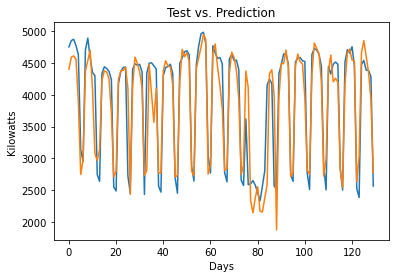

In [47]:
plt.plot(Y_test)
plt.plot(predictions)
plt.xlabel('Days')
plt.ylabel('Kilowatts')
plt.title("Test vs. Prediction")
plt.show()